useful doc: https://photutils.readthedocs.io/en/stable/background.html

In [5]:
# math symbols
med = r"$\tilde{x}$"
biw_loc = r"$\zeta_{\text{biloc}}$"
mean_symbol = r'$\bar{x}$' 
std_symbol = r'$\sigma$'    

In [6]:
import data_preprocess
from data_preprocess import preprocess_utils as preprocess_u

In [35]:
input_file =  "../XMM_OM_dataset/zscaled_512_stretched/S0404350101_L.png"

usual_input_file = '/workspace/raid/OM_DeepLearning/XAMI/spring.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


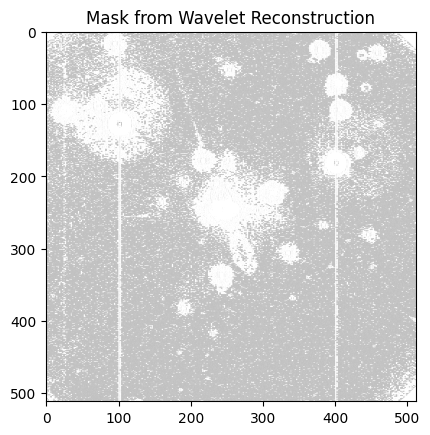

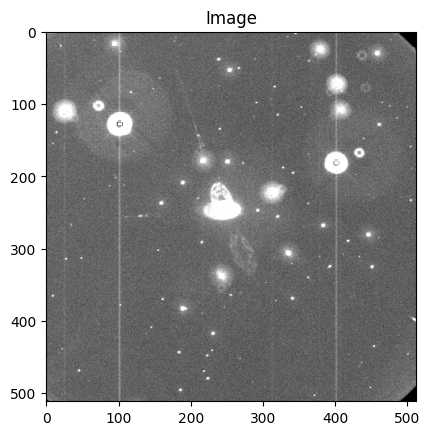

In [75]:
import cv2
import pywt
import numpy as np
import matplotlib.pyplot as plt

# image should be a 2D numpy array
image = cv2.imread(input_file)

lower_intensity = 80
upper_intensity = 110

# Perform a 2-level wavelet decomposition
coeffs = pywt.wavedec2(image, 'haar', level=1)

# coeffs is a list where coeffs[0] is the approximation coefficients (cA) at the highest level,
# and coeffs[1:] are details coefficients (cD) at each level [(cH, cV, cD), (cH, cV, cD), ...]

# For this example, let's process the approximation coefficients at level 2
cA2 = coeffs[0]
cA2_normalized = (cA2 - cA2.min()) / (cA2.max() - cA2.min())
mask = np.logical_and(cA2_normalized > lower_intensity / 255, cA2_normalized < upper_intensity / 255)

# Now, instead of directly using this mask, let's modify the approximation coefficients based on this mask
# and then perform an inverse transform to get back to the original dimensions.

# Let's create a modified version of the approximation coefficients to use in reconstruction
# For simplicity, let's set the approximation coefficients to 0 where the mask is False
modified_cA2 = np.where(mask, cA2, 0)

# Update the coeffs list with the modified approximation coefficients
coeffs[0] = modified_cA2

# Perform the inverse wavelet transform using the modified coeffs
reconstructed_image = pywt.waverec2(coeffs, 'haar')

# Since the inverse might introduce slight discrepancies in dimensions due to padding,
# we'll trim the reconstructed image to match the original dimensions
reconstructed_image = reconstructed_image[:image.shape[0], :image.shape[1]]

# At this point, you might want to threshold the reconstructed image again to get a binary mask
# Or, use the reconstructed_image as a mask directly based on your application needs
normalised_mask = (reconstructed_image - np.min(reconstructed_image))/(np.max(reconstructed_image) - np.min(reconstructed_image))
# Display the mask
plt.imshow(reconstructed_image/255, cmap='gray')
plt.title('Mask from Wavelet Reconstruction')
plt.show()
plt.close()
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()
plt.close()

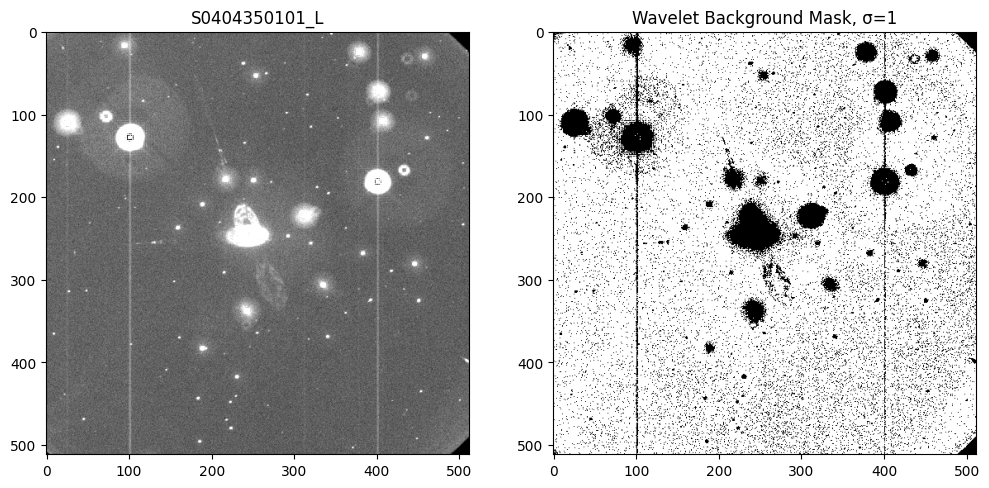

In [132]:
import numpy as np
import pywt
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("../XMM_OM_dataset/zscaled_512_stretched/S0404350101_L.png", cv2.IMREAD_GRAYSCALE)
sigma = 1
decomposition = 'db1'
coeffs = pywt.wavedec2(image, decomposition, level=2) # Daubechies 1
cA2, (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs

# Reconstruct the background image from the approximation coefficients
background = pywt.waverec2((cA2, (None, None, None), (None, None, None)), decomposition)

# Calculate the mean and standard deviation of the background
mean_bg = np.mean(background)
std_bg = np.std(background)
lower_bound = mean_bg - std_bg * sigma
upper_bound = mean_bg + std_bg * sigma

# Create a mask where pixel intensities are close to the background
mask = (image >= lower_bound) & (image <= upper_bound)
close_to_background = image * mask

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].title.set_text('S0404350101_L')
ax[1].imshow(mask, cmap='gray')
ax[1].title.set_text('Wavelet Background Mask, σ=1')
plt.savefig('./plots/wt_image_and_mask.png')
plt.show()

In [16]:
np.min(close_to_background), np.max(close_to_background), np.mean(close_to_background)

(0, 142, 96.63540267944336)

In [14]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization.mpl_normalize import ImageNormalize

usual_image = cv2.imread(usual_input_file, cv2.IMREAD_COLOR)
usual_data = cv2.cvtColor(usual_image, cv2.COLOR_BGR2RGB)

image = cv2.imread(input_file, cv2.IMREAD_COLOR)
data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

data_2D = np.dot(data[..., :3], [0.21, 0.72, 0.07]) 
usual_data_2D = np.dot(usual_data[..., :3], [0.21, 0.72, 0.07]) 

usual_data = cv2.resize(usual_data, (512, 512), interpolation=cv2.INTER_LINEAR)

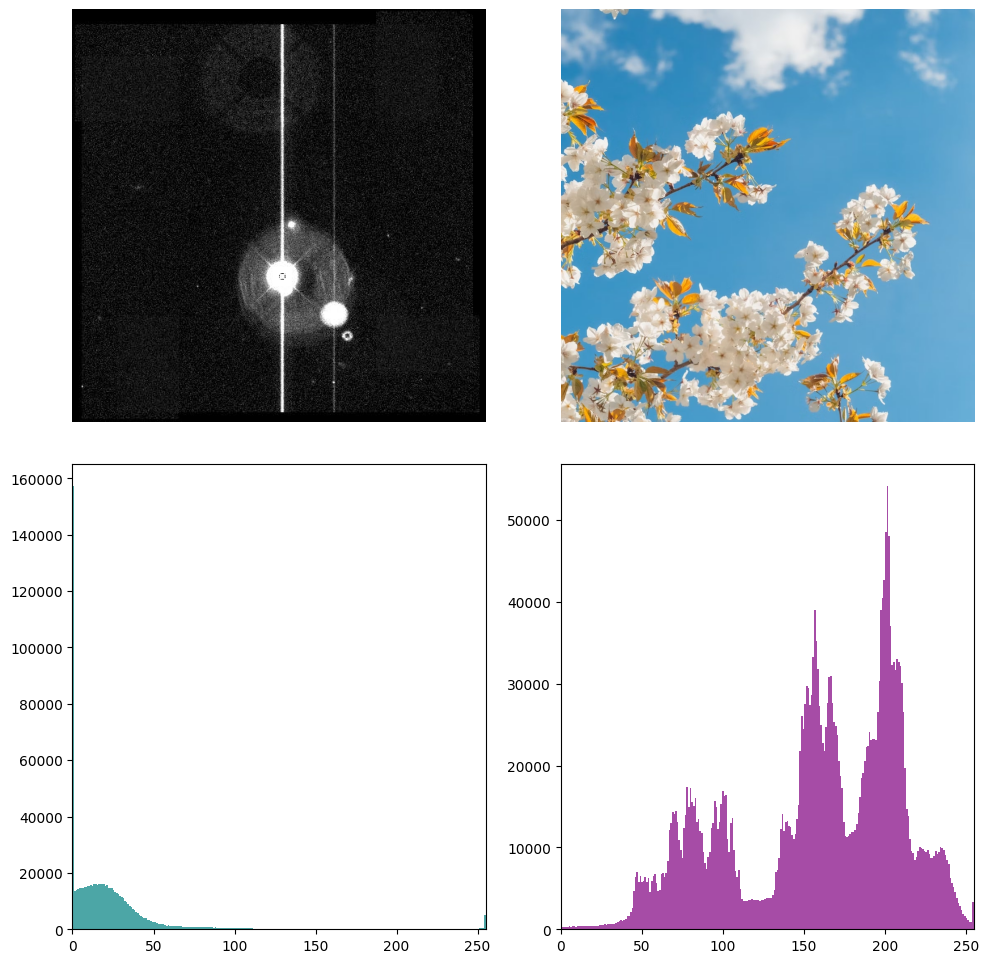

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(data, cmap='gray')
# axs[0, 0].set_title(f"Image 1 Stats\nmean: {stats1['mean']:.2f}, median: {stats1['median']:.2f}, "
#                      f"bi_loc: {stats1['bi_loc']:.2f}, std: {stats1['std']:.2f}")
axs[0, 0].axis('off')

axs[1, 0].hist(data.ravel(), bins=256, color='teal', alpha=0.7)
axs[1, 0].set_xlim([np.min(data), np.max(data)])

axs[0, 1].imshow(usual_data, cmap='gray')
# axs[0, 1].set_title(f"Image 2 Stats\nmean: {stats2['mean']:.2f}, median: {stats2['median']:.2f}, "
#                      f"bi_loc: {stats2['bi_loc']:.2f}, std: {stats2['std']:.2f}")
axs[0, 1].axis('off')

axs[1, 1].hist(usual_data.ravel(), bins=256, color='purple', alpha=0.7)
axs[1, 1].set_xlim([np.min(usual_data), np.max(usual_data)])

plt.tight_layout()
plt.show()

In [62]:
# # Compute image statistics 
# import plotly.subplots as sp

# stats1 = {
#     'mean': np.mean(data),
#     'median': np.median(data),
#     'std': np.std(data)
# }
# stats2 = {
#     'mean': np.mean(usual_data),
#     'median': np.median(usual_data),
#     'std': np.std(usual_data)
# }
# import plotly.graph_objects as go
# import plotly.subplots as sp
# import numpy as np

# fig = sp.make_subplots(
#     rows=2, cols=2,
#     row_heights=[0.5, 0.5], 
#     vertical_spacing=0.1, 
#     subplot_titles=(
#         f"μ = {stats1['mean']:.2f}, σ = {stats1['std']:.2f} <br>median = {stats1['median']:.2f}",
#         f"μ = {stats2['mean']:.2f}, σ = {stats2['std']:.2f} <br>median = {stats2['median']:.2f}",
#         "",
#         ""
#     )
# )

# fig.add_trace(go.Image(z=data), row=1, col=1)
# fig.add_trace(go.Image(z=usual_data), row=1, col=2)
# fig.update_layout(title_font=dict(family="Arial", size=18))

# fig.add_trace(go.Histogram(x=data.flatten(), nbinsx=256, marker_color='plum'), row=2, col=1)
# fig.add_trace(go.Histogram(x=usual_data.flatten(), nbinsx=256, marker_color='lightskyblue'), row=2, col=2)
# fig.update_layout(height=1000, width=1000, showlegend=False)
# fig.update_traces(opacity=1.0)  # Histograms opacity
# fig.update_xaxes(title_text="Pixel Value", row=2, col=1)
# fig.update_xaxes(title_text="Pixel Value", row=2, col=2)
# fig.update_yaxes(title_text="Count", row=2, col=1)
# fig.update_yaxes(title_text="Count", row=2, col=2)
# fig.write_image("./plots/stats_comparison.png",scale=2)
# fig.show()

In [63]:
import json

with open('/workspace/raid/OM_DeepLearning/XAMI/roboflow_datasets/xmm_om_artefacts_512-9-COCO/train/_annotations.coco.json') as f:
    dataset = json.load(f)

In [64]:
images = dataset['images']

img_keys = []
for i in range(len(images)):
    img_keys.append("_".join(images[i]['file_name'].split('_')[:2])+'.png')

In [65]:
img_keys

['S0152940101_B.png',
 'S0654480101_U.png',
 'S0784740101_L.png',
 'S0650840101_M.png',
 'S0748391701_L.png',
 'S0203160401_V.png',
 'S0651790101_M.png',
 'S0673610401_M.png',
 'S0201440101_V.png',
 'S0741032901_L.png',
 'S0694651401_U.png',
 'S0105260401_L.png',
 'S0821871801_M.png',
 'S0124710901_U.png',
 'S0805200401_V.png',
 'S0821310101_M.png',
 'S0305800101_U.png',
 'S0150970301_B.png',
 'S0804050201_M.png',
 'S0081340201_B.png',
 'S0741580901_M.png',
 'S0300470101_L.png',
 'S0551950601_U.png',
 'S0150790101_V.png',
 'S0157360701_S.png',
 'S0109130501_B.png',
 'S0144900101_U.png',
 'S0827031901_M.png',
 'S0123920101_L.png',
 'S0891804201_V.png',
 'S0134921101_B.png',
 'S0301650801_U.png',
 'S0853220201_M.png',
 'S0852180501_L.png',
 'S0721220301_B.png',
 'S0795610401_L.png',
 'S0677610139_L.png',
 'S0764890301_U.png',
 'S0112600301_V.png',
 'S0300961001_B.png',
 'S0152833001_S.png',
 'S0720110601_L.png',
 'S0670120401_V.png',
 'S0883040201_L.png',
 'S0674491501_L.png',
 'S0550460

**AsinhStretch and LogStretch**

In [ ]:
from astropy.visualization import AsinhStretch, LogStretch

# mask negative pixels
# data = 255 - data
normalized_data = data/255.0
negative_mask = (data>0).astype(int)
non_negative_data = normalized_data * negative_mask

asinh_factor = 0.1
log_factor = 100.0
# Apply AsinhStretch
data_asinh_stretched = image_stretch(non_negative_data, 'asinh', asinh_factor)

# Apply LogStretch
data_log_stretched = image_stretch(non_negative_data, 'log', log_factor)

# Gamma correction
gamma = 2
gamma_corrected = np.uint8(((1.0-non_negative_data) ** gamma)*255.0)

def plot_image_statistics(data, mask_on_negative_area=True):

        if mask_on_negative_area:
            data = data[data>0]
            
        data_median = np.median(data[data>0]).round(3)
        data_biw = biweight_location(data[data>0]).round(3)
        data_mean = np.mean(data[data>0]).round(3)
        data_std = np.std(data[data>0]).round(3)

        return f" x͂ = {data_median}, ζ_biw = {data_biw}\n x̄ = {data_mean}, σ = {data_std}"

plt.figure(figsize=(15, 10)) 

plt.subplot(2,4,1)
plt.imshow(data,cmap='gray')
plt.title(f'Image {input_file.split("/")[-1]}\n {plot_image_statistics(non_negative_data, mask_on_negative_area=True)}')

plt.subplot(2,4,2)
plt.imshow(data_asinh_stretched)
plt.title(f'Asinh Stretch factor = {asinh_factor}\n {plot_image_statistics(data_asinh_stretched, mask_on_negative_area=True)}')

plt.subplot(2,4,3)
plt.imshow(data_log_stretched)
plt.title(f'Log Stretch factor = {log_factor}\n {plot_image_statistics(data_log_stretched, mask_on_negative_area=True)}')

# plt.subplot(2,4,4)
# plt.imshow(gamma_corrected)
# plt.title(f'Gamma correction (γ = {gamma})\n {plot_image_statistics(gamma_corrected/255.0, mask_on_negative_area=True)}')

plt.subplot(2,4,4)
plt.imshow(1-data_log_stretched)
plt.title(f'Inverted Log stretch\n {plot_image_statistics((1-data_log_stretched), mask_on_negative_area=True)}')

plt.subplot(2,4,5)
plt.hist(np.dot(normalized_data[..., :3], [0.21, 0.72, 0.07]).flatten(), bins=100)
plt.title("Normalized 2D Image histogram")

plt.subplot(2,4,6)
plt.hist(data_asinh_stretched.flatten(), bins=100)  
plt.title("Asinh Stretched Image histogram")

plt.subplot(2,4,7)
plt.hist(data_log_stretched.flatten(), bins=100)  
plt.title("Log Stretched Image histogram")

plt.subplot(2,4,8)
plt.hist(gamma_corrected.flatten(), bins=100)  
plt.title("Gamma correction Image histogram")

plt.savefig('./plots/asinh_log_stretches.png', dpi=500)

plt.show()
plt.close()

In [ ]:
# import os
# import glob

# directory = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/zscaled_512_stretched/'
# files = glob.glob(f'{directory}/*')
# for file in files:
#     os.remove(file)

In [66]:
def normalize_image_to_0_255(image):
    # Find the min and max pixel values
    min_val = np.min(image)
    max_val = np.max(image)

    # Normalize the image to 0-1
    normalized_image = (image - min_val) / (max_val - min_val)

    # Scale to 0-255 and convert to uint8
    final_image = (normalized_image * 255).astype(np.uint8)

    return final_image


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

dir_in = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw_512/'
output_dir = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/zscaled_512_stretched/'
import math
k=0

for img_key in os.listdir(dir_in): # in os.listdir(dir_in):
    if '.png' in img_key and 'clahe' not in img_key:
        k+=1
        
        image_in = cv2.imread(dir_in+img_key)
        data_in = cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB)
        # data_in = 255-data_in
        use_stretch, use_clahe = False, False
        
        # print('mean:', np.mean(data_in[data_in>0])/255.0, 'std:', np.std(data_in[data_in>0])/255.0)
        
        # if use_clahe:
        #     data_in = clahe_algo_image(dir_in+file_, clipLimit=4.0, tileGridSize=(5,5))
        #     print(np.mean(data_in)/255.0, np.std(data_in)/255.0)

        if True:
            if np.max(data_in) !=0 and np.max(data_in) != np.min(data_in):
                
                normalized_data = (data_in - np.max(0, np.min(data_in)))/(np.max(data_in) - np.max(0, np.min(data_in))) # normalized up to 0 values, not less
            # else:
            #     normalized_data = 
                
            negative_mask = (data_in>0).astype(int)
            non_negative_data = normalized_data * negative_mask
            data_mean = np.mean(non_negative_data[non_negative_data>0])
            
            if not np.any(non_negative_data):
                continue
                
            if data_mean < 0.3:
                asinh_factor = 0.2
                factor = f'Asinh (factor = {asinh_factor})'
                stretched_data = preprocess_u.image_stretch(non_negative_data, 'asinh', asinh_factor)
            # elif data_mean > 0.5:
            #     gamma = 2
            #     factor = f'Gamma correction (γ = {gamma})'
            #     stretched_data = np.uint8((non_negative_data ** gamma) * 255.0)
            #     cv2.imwrite(output_file, stretched_data)
                
                # stretched_data = stretched_data/255.0
            else:
                asinh_factor = 0.5
                factor = f'Asinh (factor = {asinh_factor})'
                stretched_data = preprocess_u.image_stretch(non_negative_data, 'asinh', asinh_factor)

        output_file = output_dir+img_key
        cv2.imwrite(output_file, stretched_data*255.0)
        # fig, axs = plt.subplots(1, 2, figsize=(20, 8)) 

        # axs[0].imshow(data_in)
        # axs[0].set_title(f'{img_key}\nx̄ = {np.mean(non_negative_data[non_negative_data<255]).round(3)}, σ = {np.std(non_negative_data[non_negative_data<255]).round(3)}', fontsize=12)

        # axs[1].imshow(stretched_data)
        # axs[1].set_title(f'Stretched image\n{factor}\nx̄ = {np.mean(stretched_data[stretched_data<255]).round(3)}, σ = {np.std(stretched_data[stretched_data<255]).round(3)}', fontsize=12)

        # plt.tight_layout()
        
        # plt.show()
        # plt.close()

/opt/conda/envs/env_py311/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/opt/conda/envs/env_py311/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



In [69]:
import os
from PIL import Image
import numpy as np

image_dir = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/zscaled_512_stretched/'
all_images = []
stds_images = []
max_mean = 0
min_mean = 1000
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image = Image.open(os.path.join(image_dir, filename))

        image_array = np.array(image) 
        if not np.any(image_array):
            continue
        max_mean = max(max_mean, np.mean(image_array[image_array>0]))
        min_mean = min(min_mean, np.mean(image_array[image_array>0]))
        
        all_images.append(np.mean(image_array[image_array>0]))
        stds_images.append(np.std(image_array[image_array>0]))

print('Mean of means all images:', np.mean(all_images)/255.0, ' Std:', np.std(all_images)/255.0)
print('Mean of stds all images:', np.mean(stds_images)/255.0, ' Std:', np.std(stds_images)/255.0)

Mean of means all images: 0.35346607259145885  Std: 0.10445250962587775
Mean of stds all images: 0.13405538496778155  Std: 0.042044878552709115


In [ ]:
# dir_files = [file_ for file_ in os.listdir(output_dir)]

# for im_key in img_keys:
#     for f in dir_files:
#         if im_key in f:
#             print(im_key, f)

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

image = cv2.imread('/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw_512/S0202730101_B.png', cv2.IMREAD_GRAYSCALE)

gamma = 1.5
gamma_corrected = np.uint8(((image / 255.0) ** gamma) * 255.0)

# Plot original and gamma-corrected images
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Gamma-Corrected Image (γ=1.5)')
plt.imshow(gamma_corrected, cmap='gray')

plt.show()
plt.close()

cv2.imwrite(f'/plots/gamma_.png', gamma_corrected)

In [ ]:
np.mean(image)/255, np.std(image)/255,np.mean(gamma_corrected)/255, np.std(gamma_corrected)/255

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# datasets = {
#     "SA-1B": np.random.rand(1000, 2),
#     "LVIS v1": np.random.rand(1000, 2),
#     "COCO": np.random.rand(1000, 2),
#     "ADE20K": np.random.rand(1000, 2),
#     "Open Images": np.random.rand(1000, 2)
# }

# fig, axes = plt.subplots(1, len(datasets), figsize=(15, 3))

# for ax, (title, data) in zip(axes, datasets.items()):
#     sns.kdeplot(x=data[:, 0], y=data[:, 1], ax=ax, fill=True, cmap='magma')
#     ax.set_title(title)
#     ax.axis('off')  

# plt.tight_layout()
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

centers_array =  np.array(get_normalized_centers(data_2D))

# Telescope filter Statistics

The usual filters of the Optical Monitor are:
* M, U, L, V, B, S, W

/tmp/ipykernel_660403/987871607.py:59: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



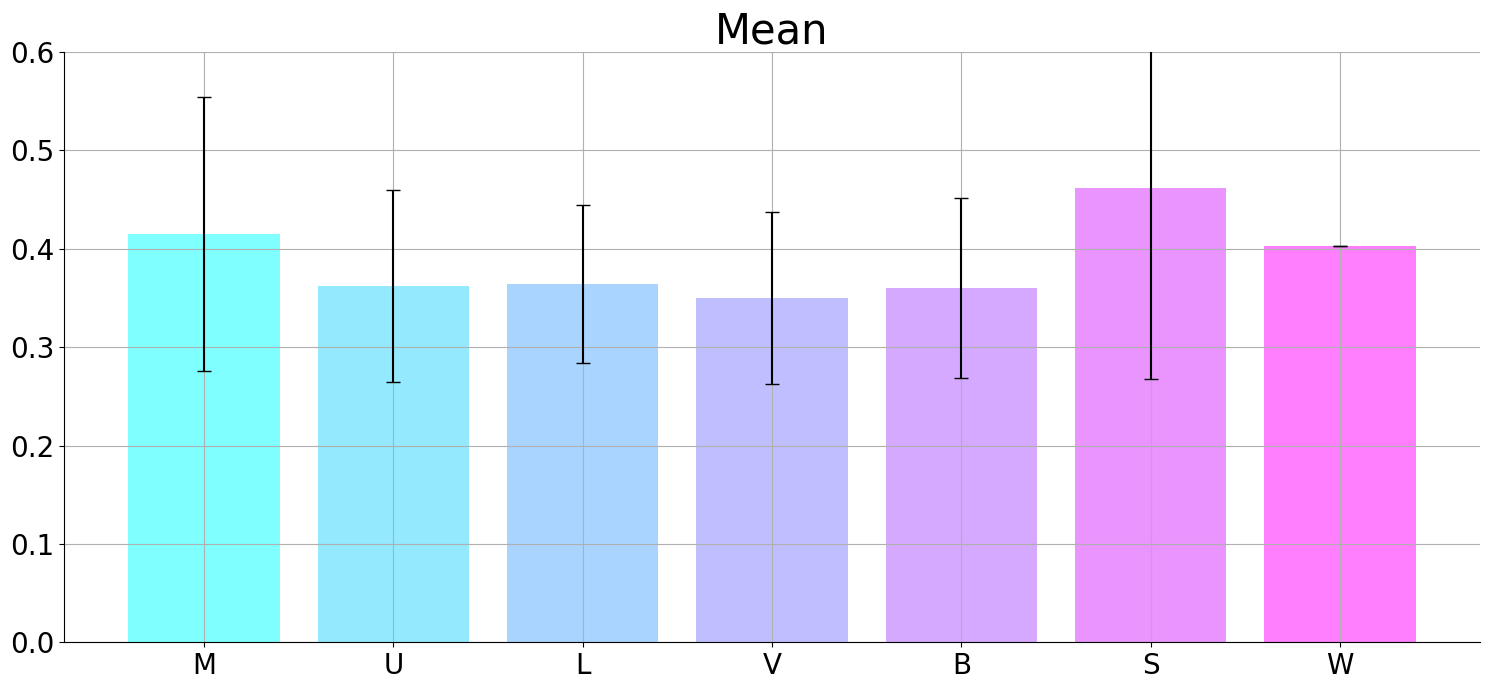

In [34]:
import os
from PIL import Image
import numpy as np
from astropy.stats import biweight_location
from collections import defaultdict
import matplotlib.pyplot as plt

def calculate_filter_statistics(path, image_files):
    group_means = {}
    group_stds = {}
    group_medians = {}
    group_biweight_locs = {}
    stds_mean = {}
    stds_stds = {}
    stds_median = {}
    stds_biw = {}
    
    for group, images in image_files.items():
        means = []
        stds = []
        medians = []
        biweight_locs = []

        for image_file in images:
            # new_path = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw_512/'
            image = Image.open(os.path.join(folder_path, image_file)) 
            # image = Image.open(os.path.join(path, image_file)) 
            
            image_array = np.array(image)/255.0
            positive_pixels = image_array[image_array > 0]
            if positive_pixels.size > 1:
                means.append(np.mean(positive_pixels))
                stds.append(np.std(positive_pixels))
                medians.append(np.median(positive_pixels))
                biweight_locs.append(biweight_location(positive_pixels))

        group_means[group] = np.mean(means)
        group_stds[group] = np.mean(stds)
        group_medians[group] = np.mean(medians)
        group_biweight_locs[group] = np.mean(biweight_locs)

        stds_mean[group] = np.std(means)
        stds_stds[group] = np.std(stds)
        stds_median[group] = np.std(medians)
        stds_biw[group] = np.std(biweight_locs)
        
    # SAM standard statistics
    pixel_mean = np.array([123.675, 116.28, 103.53])/255.0
    pixel_std = np.array([58.395, 57.12, 57.375])/255.0

    # Generate some data
    data = [np.clip(np.random.normal(mu, sigma, 1000), 0, 1) for mu, sigma in zip(pixel_mean, pixel_std)]    
    colors_sam = ['r', 'g', 'b']
    labels = ['Red Channel', 'Green Channel', 'Blue Channel']

    import matplotlib.cm as cm

    n = len(group_means)
    colors = cm.get_cmap('cool', n)(np.arange(n))
    colors[:, -1] = 0.5 

    # fig, ax = plt.subplots(figsize=(15, 7)) 
    
    # ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    # ax.grid(True)
    # ax.tick_params(axis='x', labelsize=20)  # Set x-axis label size
    # ax.tick_params(axis='y', labelsize=20)  # Set y-axis label size
    
    # # Assuming group_means and stds_mean are dictionaries with your data
    # # ax.bar(range(len(group_means)), list(group_means.values()), yerr=list(stds_mean.values()),
    # #        tick_label=list(group_means.keys()), color=colors, capsize=5)
    # ax.bar(range(len(group_stds.values())), group_stds.values(),  yerr=list(stds_stds.values()), 
    #        tick_label=list(image_files.keys()), color=colors, capsize=5)
    # # ax.axhline(y=0.45, color='red', linestyle='--', linewidth=5) 
    # ax.set_ylim([0, 0.2])
    # ax.set_title('Std', fontsize=30)
    
    # plt.tight_layout()
    # plt.savefig('./plots/std_raw_512.png')
    # plt.show()
    
    fig, ax = plt.subplots(figsize=(15, 7)) 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(True)
    ax.tick_params(axis='x', labelsize=20)  # Set x-axis label size
    ax.tick_params(axis='y', labelsize=20)  # Set y-axis label size
    
    # Assuming group_means and stds_mean are dictionaries with your data
    ax.bar(range(len(group_means)), list(group_means.values()), yerr=list(stds_mean.values()),
           tick_label=list(group_means.keys()), color=colors, capsize=5)
    
    # ax.axhline(y=0.45, color='red', linestyle='--', linewidth=5) 
    ax.set_ylim([0, 0.6])
    ax.set_title('Mean', fontsize=30)
    
    plt.tight_layout()
    plt.savefig('./plots/mean_zscaled_512.png')
    plt.show()
    
    # fig, axs = plt.subplots(1, 2, figsize=(30, 7))
    
    # for ax in axs:
    #     ax.spines['right'].set_visible(False)
    #     ax.spines['top'].set_visible(False)
    #     ax.grid(True)
    #     ax.tick_params(axis='x', labelsize=20)  # Set x-axis label size
    #     ax.tick_params(axis='y', labelsize=20)  # Set y-axis label size
    
    # axs[0].bar(range(len(group_means)), list(group_means.values()), yerr=list(stds_mean.values()), 
    #        tick_label=list(image_files.keys()), color=colors, capsize=5)
    # axs[0].axhline(y=0.45, color='red', linestyle='--', linewidth=5) 

    # axs[1].bar(range(len(group_stds.values())), group_stds.values(),  yerr=list(stds_stds.values()), 
    #        tick_label=list(image_files.keys()), color=colors, capsize=5)
    # axs[1].axhline(y=0.22, color='red', linestyle='--', linewidth=5) 
    
    # axs[0].set_title('Mean', fontsize=30)
    # axs[1].set_title('Std', fontsize=30)
    
    # plt.tight_layout()
    # plt.savefig('./plots/statistics_XMM_OM_images_vs_SAM.png', dpi=500)
    # plt.show()
    
# folder_path = '/workspace/raid/OM_DeepLearning/XAMI/roboflow_datasets/xmm_om_artefacts_512-7-COCO/train'
folder_path = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/zscaled_512_stretched/'

file_groups = {}

k=0
for filename in os.listdir(folder_path)[:1000]:
    if True: #k<200:
        k+=1
        file_path = os.path.join(folder_path, filename)
        
        if os.path.isfile(file_path) and (filename.endswith(".jpg") or filename.endswith(".png")) and 'clahe' not in filename:
            key = filename.split('.')[0].replace('_png', '')[-1]
            if key in file_groups:
                file_groups[key].append(file_path)
            else:
                file_groups[key] = [file_path]

calculate_filter_statistics(folder_path, file_groups)

In [ ]:
folder_path = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw_512/'
file_groups = {}

k=0
for filename in os.listdir(folder_path):
    if True: #k<200:
        k+=1
        file_path = os.path.join(folder_path, filename)
    
        if os.path.isfile(file_path) and (filename.endswith(".jpg") or filename.endswith(".png")) and 'clahe' not in filename:
            key = filename.split('.')[0][-1]
            if key in file_groups:
                file_groups[key].append(file_path)
            else:
                file_groups[key] = [file_path]

calculate_filter_statistics(folder_path, file_groups)

In [ ]:
# Plot image-size normalized mask center distribution using kernel density estimation given extracted sources. 

# fig, ax = plt.subplots(figsize=(5, 5))  # Corrected line

# sns.kdeplot(x=centers_array[:, 0], y=centers_array[:, 1], fill=True, ax=ax, cmap='magma', warn_singular=False)
# ax.set_title(f'XMM-Newton Optical Monitor\nImage-size normalized mask center distribution', fontsize=10, fontfamily='monospace')
# # ax.axis('off')
# ax.set_xlabel("norm-X")
# ax.set_ylabel("norm-Y")

# plt.tight_layout()
# plt.show()

In [ ]:
# sigma clipping
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
print((mean, median, std))  

# Source extraction with sigma clipping and background estimation

It's necessary to analyse the CDF of the image data in order to choose good sigma values for clipping.

In [ ]:
import os
import glob
from collections import defaultdict

def group_files_by_substrings(path, substrings):
    all_files = glob.glob(os.path.join(path, '*'))

    groups = defaultdict(list)

    for file in all_files:
        for substring in substrings:
            keyy = file.split('/')[-1][12]
            if substring in keyy:
                groups[substring].append(file)

    return groups
    
path_ = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/zscaled_512_stretched/'
substrings = ['M', 'U', 'L', 'V', 'B', 'S', 'W']
groups = group_files_by_substrings(path_, substrings)

# cdfs = defaultdict(list)
# for keyy, path_list in groups.items():
#     for img_path in path_list:
#             image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#             data_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
#             data_2D_img = np.dot(data_img[..., :3], [0.21, 0.72, 0.07])
#             data_2D_img = data_2D_img[data_2D_img>0]
#             # Calculate the CDF
#             sorted_values = np.sort(data_2D_img.flatten())
#             cumulative = np.cumsum(sorted_values)  # Cumulative sum
#             cdf = cumulative / cumulative[-1]  # Normalization
#             cdfs[keyy].append(cdf)

#     average_prob = np.mean(cdfs[keyy], axis=0)
#     cdfss = np.cumsum(average_prob)
#     # print(cdfss)
#     # if keyy == 'L':
#     plt.plot(sorted_values, cdfss, label=img_path)
    
#     plt.title(f"CDFs of Image Pixel Intensities ({keyy} filter)")
#     plt.xlabel("Pixel Intensity")
#     plt.ylabel("Cumulative Distribution")
#     ax.legend()
    
#     plt.tight_layout()
#     plt.savefig(f'./plots/CDF_filter{keyy}.png', dpi=300)
#     plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

def find_changes(cdf):
    second_derivative = np.gradient(np.gradient(cdf))
    changes_indices = np.where(np.diff(np.sign(second_derivative)))[0]
    return changes_indices

sorted_values = np.sort(data_2D.flatten())
cumulative = np.cumsum(sorted_values)  # Cumulative sum
cdf = cumulative / cumulative[-1]  # Normalization

plt.plot(sorted_values, cdf)

plt.title(f"CDF of Image Pixel Intensities")
plt.xlabel("Pixel Intensity")
plt.ylabel("Cumulative Distribution")
plt.legend()

plt.axvline(x=85, color='r', linestyle='--')
plt.axvline(x=135, color='r', linestyle='--')

plt.tight_layout()
plt.savefig(f'./plots/CDF_.png', dpi=300)
plt.show()

changes_indices = find_changes(cdf)
changes_indices

sigma_values = sorted_values[changes_indices]
len(sigma_values)

In [ ]:
plt.imshow(data_2D, cmap='gray')

In [ ]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

x = np.arange(len(sorted_values))
y = sorted_values

xlog = np.log10(x[1:]) 

# Create spline
spline = UnivariateSpline(xlog, y[1:])

plt.figure(figsize=(7,5))
plt.plot(xlog, spline(xlog), 'b-', lw=2)  # Spline
plt.plot(xlog, y[1:], 'ro')  # Original data
plt.show()

# # Compute second derivative
# spline_deriv2 = spline.derivative(n=2)

# # Find roots of the second derivative
# inflexion_points = spline_deriv2.roots()

# # Print inflexion points
# print(inflexion_points)

x = np.linspace(np.min(sorted_values), np.max(sorted_values), num=len(sorted_values))  
y = spline(cdf)

plt.figure(figsize=(7,5))
plt.plot(y, 'b-', lw=2)  # Spline
plt.grid(True)
plt.show()

# Find where y-values change sign
roots = x[:-1][np.diff(np.sign(y)) != 0]

In [ ]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

# Log transform x
xlog = np.log10(x[1:])  # Exclude the first element because log10(0) is undefined

# Create spline
spline = UnivariateSpline(xlog, y[1:])

# Plot
plt.figure(figsize=(7,5))
plt.plot(xlog, spline(xlog), 'b-', lw=2)  # Spline
plt.plot(xlog, y[1:], 'ro')  # Original data
plt.show()

In [ ]:
roots

In [ ]:
# from scipy.signal import savgol_filter

# smoothed_cdf = savgol_filter(cdf, window_length=5, polyorder=2)

# plt.plot(sorted_values, smoothed_cdf)
# plt.title("Smoothed CDF")
# plt.xlabel("Pixel Intensity")
# plt.ylabel("Cumulative Distribution")
# plt.legend()
# plt.show()

from scipy.interpolate import interp1d

interp_func = interp1d(sorted_values, cdf, kind='linear')

new_sorted_values = np.linspace(sorted_values.min(), sorted_values.max(), 1000)
smoothed_cdf = interp_func(new_sorted_values)

plt.plot(new_sorted_values, smoothed_cdf)
plt.title("Interpolated CDF")
plt.xlabel("Pixel Intensity")
plt.ylabel("Cumulative Distribution")
plt.legend()
plt.show()

In [ ]:
changes_indices = find_changes(smoothed_cdf)
sigma_values = new_sorted_values[changes_indices]
len(sigma_values)

## Source detection and deblend + bboxes

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict 

hw_threshold = 5
clip_sigmas = [3]
kernel_sigma = 1.5
npixels = 10
sigma_kernel = r"${\sigma}_{\mathrm{kernel}}$"
sigma_clip = r"${\sigma}_{\mathrm{clip}}$"

bboxes = defaultdict(dict)
points = defaultdict(dict)

input_dir = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/zscaled_512_stretched/'
# file_name = '/workspace/raid/OM_DeepLearning/XMM_OM_code/scaled_raw/clahe_S0601270201_B.png'

if 1==1:
    for file_name in os.listdir(input_dir):
        if 'clahe' not in file_name and file_name.endswith('.png'):
            
            image = cv2.imread(input_dir+file_name, cv2.IMREAD_GRAYSCALE)
            data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            data_2D = np.dot(data[..., :3], [0.21, 0.72, 0.07]) 
            
            bboxes[file_name] = [] # some observations may have 0 boxes
            points[file_name] = [] 
                        
            for clip_sigma in clip_sigmas:
                segment_map, segment_map_finder, sources_tbl_with_hw_threshold = detect_and_deblend_sources(data_2D, hw_threshold=hw_threshold, clip_sigma=clip_sigma, 
                                                                                    kernel_sigma=kernel_sigma, npixels=npixels, verbose=True)
                if sources_tbl_with_hw_threshold is not None:
    
                    plt.imshow(data_2D, cmap='gray')
                    for source in sources_tbl_with_hw_threshold:
                        x, y = source['xcentroid'], source['ycentroid']
                        semimajor = source['semimajor_sigma'].value * 4
                        semiminor = source['semiminor_sigma'].value * 4
                        theta = source['orientation'].value 
                        ellipse = patches.Ellipse((x, y), 2*semimajor, 2*semiminor, angle=theta, 
                                              edgecolor='green', facecolor='none')
                        plt.gca().add_patch(ellipse)
                        
                        xmin = source['bbox_xmin']-4 # slightly enlarge the bbox 
                        xmax = source['bbox_xmax']+3
                        ymin = source['bbox_ymin']-3
                        ymax = source['bbox_ymax']+3
            
                        width = xmax - xmin
                        height = ymax - ymin
                        bboxes[file_name].append([int(xmin), int(ymin), int(width), int(height)])
                        points[file_name].append([float(x), float(y)])
                        
                        rect = patches.Rectangle((xmin, ymin), width, height, edgecolor='red', facecolor='none')
                        plt.gca().add_patch(rect)
                
                    plt.title(f'{file_name}\nsources + bboxes, hidth-witdh > {hw_threshold} px\n{sigma_clip} = {clip_sigma}, {sigma_kernel} = {kernel_sigma}'+\
                            f', {len(sources_tbl_with_hw_threshold)} bboxes', fontsize=10, fontfamily='monospace')
                    plt.colorbar()
                    plt.show()
                    plt.close()
                else:
                    print('No sources found at σ =', clip_sigma)
if 1==1:
    import json
    
    json_dict = {"bboxes": bboxes, "points": points}
    
    with open('extracted_sources_bboxes_points.json', 'w') as f:
        json.dump(json_dict, f)

**one image run**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict 

file_name = image_path = "/workspace/raid/OM_DeepLearning/XAMI/xmm_om_images-contrast-512-v5-3/train/S0202130101_L_png.rf.180755edd461c3df5224f9311c184ba6.jpg"
image = cv2.imread(file_name, cv2.IMREAD_COLOR)
data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

data_2D = np.dot(data[..., :3], [0.21, 0.72, 0.07]) 

bboxes = defaultdict(list)
points = defaultdict(list)

hw_threshold = 5
clip_sigmas = [4]
kernel_sigma = 3
npixels = 100

sigma_kernel = r"${\sigma}_{\mathrm{kernel}}$"
sigma_clip = r"${\sigma}_{\mathrm{clip}}$"


for clip_sigma in clip_sigmas:
    segment_map, segment_map_finder, sources_tbl_with_hw_threshold = detect_and_deblend_sources(data_2D, hw_threshold=hw_threshold, clip_sigma=clip_sigma, 
                                                                          kernel_sigma=kernel_sigma, npixels=npixels, verbose=True)
    if sources_tbl_with_hw_threshold is not None:

        plt.imshow(data_2D, cmap='gray')
        for source in sources_tbl_with_hw_threshold:
            x, y = source['xcentroid'], source['ycentroid']
            semimajor = source['semimajor_sigma'].value * 2.5
            semiminor = source['semiminor_sigma'].value * 2.5
            theta = source['orientation'].value 
            ellipse = patches.Ellipse((x, y), 2*semimajor, 2*semiminor, angle=theta, 
                                      edgecolor='green', facecolor='none')
            plt.gca().add_patch(ellipse)
        
            xmin = source['bbox_xmin']-3 # slightly enlarge the bbox 
            xmax = source['bbox_xmax']+3
            ymin = source['bbox_ymin']-3
            ymax = source['bbox_ymax']+3

            width = xmax - xmin
            height = ymax - ymin
            bboxes[file_name].append([int(xmin), int(ymin), int(width), int(height)])
            points[file_name].append([float(x), float(y)])
            
            rect = patches.Rectangle((xmin, ymin), width, height, edgecolor='red', facecolor='none')
            plt.gca().add_patch(rect)
    
        plt.title(f'{file_name.split("/")[-1].split(".")[0]}\nsources + bboxes, hidth-witdh > {hw_threshold} px\n{sigma_clip} = {clip_sigma}, {sigma_kernel} = {kernel_sigma}'+\
                  f', {len(sources_tbl_with_hw_threshold)} bboxes', fontsize=10, fontfamily='monospace')
        plt.colorbar()
        plt.savefig('./plots/detected_sources.png', dpi=1000)
        
        plt.show()
        plt.close()
    else:
        print('No sources found at σ =', clip_sigma)

In [ ]:
print(f'Median = {np.median(data_2D[data_2D>0])/255.0}. Mean = {np.mean(data_2D[data_2D>0])/255.0}. Std = {np.std(data_2D[data_2D>0])/255.0}')